# Questions
- How does the following factors affect the chance of getting at least one correct answer:
- number of attempts
- level of help
- time spent
- number of incorrect attempts


In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import os

from pandasql import sqldf
import pickle

import warnings
from datetime import datetime, timedelta, date
import time
import sys

%matplotlib inline

# Function to start timer on cell execution
def timer_start():
    global start
    start = time.time()
    print("Cell initiated at " + str(datetime.now()))

# Function to stop timer on cell execution
def timer_stop():
    stop = time.time()
    print("\nCell finished at " +str(datetime.now()) +", execution time: " + str(timedelta(seconds = stop - start)))


In [410]:
print(os.getcwd())

C:\Users\fales\Dropbox\Studier\Python\Data_scientist_nd\course_2\datascience_blogpost


# Exploratory phase
- Data is imported.
- Dataframe with relevant features is created.
- Missing values are dealt with.
- New cleaned dataframe is created with combination of sission id and step as unique identifier. 

In [412]:
from zipfile import ZipFile
ZipFile("data/ds185_tx_All_Data_508_2015_0729_201849.zip").extractall("data/")

In [413]:
# Note: This file is too large to be stored in my Git profile and DataShop doesn't provide a path. Therefore it need to first be imported manuall from 
# https://pslcdatashop.web.cmu.edu/Export?datasetId=185
# The code below assumes the file has been downloaded and saved into the data-folder

timer_start()

df_raw = pd.read_csv('data/ds185_tx_All_Data_508_2015_0729_201849.txt', delimiter = "\t", low_memory=False)

timer_stop()


Cell initiated at 2025-04-26 19:00:28.547141

Cell finished at 2025-04-26 19:00:37.110129, execution time: 0:00:08.562987


In [414]:
df_raw.head()

,Row,Sample Name,Transaction Id,Anon Student Id,Session Id,Time,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,...,KC Category (Default).1,KC (Default).2,KC Category (Default).2,KC (Single-KC),KC Category (Single-KC),KC (Unique-step),KC Category (Unique-step),School,Class,CF (media message)
0,1,All Data,a23c03d186dd18c7ee5c1f07f554420f,Stu_0078be3c7f5c3c58978ccbf06819f2a8,ec2139a880020c6801caba5cbbaa0dc4,2012-01-17 14:46:33,UTC,5,ATTEMPT,NaN,...,multiple_selection,pinyin_recognition,multiple_selection,Single-KC,NaN,KC60,NaN,Carnegie Mellon University,134longnian,NaN
1,2,All Data,599cf61fbc1c7887a72e9efec7132161,Stu_0078be3c7f5c3c58978ccbf06819f2a8,ec2139a880020c6801caba5cbbaa0dc4,2012-01-17 14:46:58,UTC,0.5,VIDEO_ACTION,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carnegie Mellon University,134longnian,Stop the video.
2,3,All Data,8aa1c7d235beec3f8bdd7013f2bf953c,Stu_0078be3c7f5c3c58978ccbf06819f2a8,ec2139a880020c6801caba5cbbaa0dc4,2012-01-17 14:46:58,UTC,0.5,VIDEO_ACTION,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carnegie Mellon University,134longnian,Stop the video.
3,4,All Data,02a5fbe8a0ea56d9d0ea3e41e5e27200,Stu_0078be3c7f5c3c58978ccbf06819f2a8,f409b55580020c6801bbb41756dbadb4,2012-01-19 03:38:06,UTC,0.5,VIDEO_ACTION,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carnegie Mellon University,134longnian,Stop the video.
4,5,All Data,e15764f18e1abb07b7857d2b73caca36,Stu_0078be3c7f5c3c58978ccbf06819f2a8,f409b55580020c6801bbb41756dbadb4,2012-01-19 03:38:06,UTC,0.5,VIDEO_ACTION,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carnegie Mellon University,134longnian,Stop the video.


In [415]:
# Making a copy of dataframe in order to avoid reading textfile multiple times
df = df_raw.copy()

### Observation
Only a few of these features are relevant for this analysis. 

### Action
Create new dataframe keeping only relevant features.

In [417]:
# creating a new dataframe with the columns needed for this analysis
df = df[['Session Id', 'Duration (sec)', 'Student Response Type', 'Tutor Response Type', 'Attempt At Step', 'Is Last Attempt', 'Outcome', 'Help Level', 'Total Num Hints', 'KC (Unique-step)']]

In [418]:
# renaming columns where spaces are removed to enable sql select and shortening names for easier presentation
df.rename(columns={"Session Id": "session_id", "Duration (sec)": "duration", "Student Response Type": "student_response", "Tutor Response Type": "tutor_response"
                  , "Attempt At Step": "attempt", "Is Last Attempt": "last_attempt", "Outcome": "outcome", "Help Level": "help_level", "Total Num Hints": "hints"
                   , "KC (Unique-step)": "step"}, inplace = True)

df.head()

,session_id,duration,student_response,tutor_response,attempt,last_attempt,outcome,help_level,hints,step
0,ec2139a880020c6801caba5cbbaa0dc4,5,ATTEMPT,RESULT,1.0,1.0,CORRECT,NaN,NaN,KC60
1,ec2139a880020c6801caba5cbbaa0dc4,0.5,VIDEO_ACTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ec2139a880020c6801caba5cbbaa0dc4,0.5,VIDEO_ACTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f409b55580020c6801bbb41756dbadb4,0.5,VIDEO_ACTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f409b55580020c6801bbb41756dbadb4,0.5,VIDEO_ACTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN


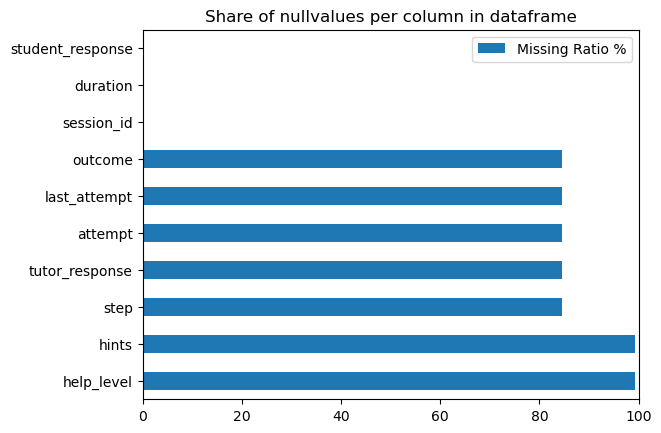

In [419]:
# Checking  nullvalues
def plot_null(df: pd.DataFrame):
    

    na_df = (df.isnull().sum() / len(df)) * 100      
    na_df = na_df.sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
    missing_data.plot(kind = "barh")
    plt.title('Share of nullvalues per column in dataframe')
    plt.xlim(0, 100)
    plt.show()
        
plot_null(df)

In [420]:
# change type for 'Duration (sec)' and replace . with 0
df['duration'] = df['duration'].astype("string")

df['duration'] = df['duration'].replace(['.'], '0')

df['duration'] = df['duration'].astype("float")

### Observation
A lot of null values here. 

### Action
For numeric features these will be replaced with 0 and for others 'missing'.

In [422]:
# create list with all features and their types
list_of_features_and_types = []
all_features = list(df)
for item in all_features:
    list_of_features_and_types.append([item, str(df[item].dtype)])

# create dataframe with feature and type
types = pd.DataFrame.from_records(list_of_features_and_types)
types.columns = ['feature', 'type']

# create new columns for cat vs num
types['unique_values'] = types['feature'].apply(lambda x: df[x].nunique())
types['unique_examples'] = types['feature'].apply(lambda x: df[x].unique()[:5])
types['number'] = np.where(types.type.str.contains('int|float'), 1, 0)
types['categorical'] = np.where((types.number == 0), 1, 0)

print('Number of features:', len(all_features))

types

Number of features: 10


,feature,type,unique_values,unique_examples,number,categorical
0,session_id,object,3655,"[ec2139a880020c6801caba5cbbaa0dc4, f409b555800...",0,1
1,duration,float64,812,"[5.0, 0.5, 18.0, 0.0, 1.0]",1,0
2,student_response,object,4,"[ATTEMPT, VIDEO_ACTION, HINT_REQUEST, AUDIO_AC...",0,1
3,tutor_response,object,2,"[RESULT, nan, HINT_MSG]",0,1
4,attempt,float64,119,"[1.0, nan, 2.0, 3.0, 4.0]",1,0
5,last_attempt,float64,2,"[1.0, nan, 0.0]",1,0
6,outcome,object,3,"[CORRECT, nan, HINT, INCORRECT]",0,1
7,help_level,float64,3,"[nan, 1.0, 2.0, 3.0]",1,0
8,hints,float64,1,"[nan, 3.0]",1,0
9,step,object,849,"[KC60, nan, KC98, KC716, KC355]",0,1


In [423]:
feature_numerical = list(types[(types.feature.isin(all_features)) & (types.number == 1)].feature.unique())

feature_categorical = list(types[(types.feature.isin(all_features)) & (types.categorical == 1)].feature.unique())

In [424]:
print('NUMERICAL:')
for item in feature_numerical:
    print(item, ':', df[item].isna().sum(), ':', df[item].mean())
    df[item] = df[item].fillna(0) # this row for 0 as missing value

NUMERICAL:
duration : 0 : 2.221614491172911
attempt : 686676 : 3.630983740937343
last_attempt : 686676 : 0.4935496963860791
help_level : 806774 : 1.6806480648064805
hints : 806774 : 3.0


In [425]:
print('CATEGORICAL:')
for item in feature_categorical:
    print(item, ':', df[item].isna().sum(), ':', 'missing')
    df[item] = df[item].fillna('missing')

CATEGORICAL:
session_id : 0 : missing
student_response : 0 : missing
tutor_response : 686676 : missing
outcome : 686676 : missing
step : 686708 : missing


In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812329 entries, 0 to 812328
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   session_id        812329 non-null  object 
 1   duration          812329 non-null  float64
 2   student_response  812329 non-null  object 
 3   tutor_response    812329 non-null  object 
 4   attempt           812329 non-null  float64
 5   last_attempt      812329 non-null  float64
 6   outcome           812329 non-null  object 
 7   help_level        812329 non-null  float64
 8   hints             812329 non-null  float64
 9   step              812329 non-null  object 
dtypes: float64(5), object(5)
memory usage: 62.0+ MB


In [427]:
# setting id to concatenation of sessionid and step
df['id'] = df['session_id'] + df['step']


In [428]:
df.head()

,session_id,duration,student_response,tutor_response,attempt,last_attempt,outcome,help_level,hints,step,id
0,ec2139a880020c6801caba5cbbaa0dc4,5.0,ATTEMPT,RESULT,1.0,1.0,CORRECT,0.0,0.0,KC60,ec2139a880020c6801caba5cbbaa0dc4KC60
1,ec2139a880020c6801caba5cbbaa0dc4,0.5,VIDEO_ACTION,missing,0.0,0.0,missing,0.0,0.0,missing,ec2139a880020c6801caba5cbbaa0dc4missing
2,ec2139a880020c6801caba5cbbaa0dc4,0.5,VIDEO_ACTION,missing,0.0,0.0,missing,0.0,0.0,missing,ec2139a880020c6801caba5cbbaa0dc4missing
3,f409b55580020c6801bbb41756dbadb4,0.5,VIDEO_ACTION,missing,0.0,0.0,missing,0.0,0.0,missing,f409b55580020c6801bbb41756dbadb4missing
4,f409b55580020c6801bbb41756dbadb4,0.5,VIDEO_ACTION,missing,0.0,0.0,missing,0.0,0.0,missing,f409b55580020c6801bbb41756dbadb4missing


In [429]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812329 entries, 0 to 812328
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   session_id        812329 non-null  object 
 1   duration          812329 non-null  float64
 2   student_response  812329 non-null  object 
 3   tutor_response    812329 non-null  object 
 4   attempt           812329 non-null  float64
 5   last_attempt      812329 non-null  float64
 6   outcome           812329 non-null  object 
 7   help_level        812329 non-null  float64
 8   hints             812329 non-null  float64
 9   step              812329 non-null  object 
 10  id                812329 non-null  object 
dtypes: float64(5), object(6)
memory usage: 68.2+ MB


In [430]:
# Creating a new dataframe with aggregated columns regarding attempts and results
query = """
SELECT 
    id
    , SUM(duration) AS duration
    , SUM(CASE WHEN outcome = 'CORRECT' THEN 1 ELSE 0 END) AS correct_count
    , CASE WHEN SUM(CASE WHEN outcome = 'CORRECT' THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END AS correct
    , SUM(CASE WHEN outcome = 'INCORRECT' THEN 1 ELSE 0 END) AS incorrect
    , SUM(CASE WHEN student_response = 'ATTEMPT' THEN 1 ELSE 0 END) AS attempts
    , ROUND(1.0 * SUM(CASE WHEN outcome = 'CORRECT' THEN 1 ELSE 0 END)/SUM(CASE WHEN student_response = 'ATTEMPT' THEN 1 ELSE 0 END), 2) AS correct_share
    , MAX(hints) AS hints
    , MAX(help_level) AS help
FROM 
    df 
GROUP BY 
    id
"""


df_clean = sqldf(query, env=None)

df_clean.head()

,id,duration,correct_count,correct,incorrect,attempts,correct_share,hints,help
0,000f5ff880020c6801167a0d4de3a10aKC153,20.0,3,1,4,7,0.43,0.0,0.0
1,000f5ff880020c6801167a0d4de3a10aKC202,2.0,1,1,0,1,1.00,0.0,0.0
2,000f5ff880020c6801167a0d4de3a10aKC225,5.0,1,1,0,1,1.00,0.0,0.0
3,000f5ff880020c6801167a0d4de3a10aKC411,3.0,1,1,0,1,1.00,0.0,0.0
4,000f5ff880020c6801167a0d4de3a10aKC442,12.0,2,1,0,2,1.00,0.0,0.0


In [431]:
df_clean.groupby(['help'])['help'].count()

help
0.0    70838
1.0      661
2.0      179
3.0      742
Name: help, dtype: int64

In [432]:
df_clean.groupby(['hints'])['hints'].count()


hints
0.0    70838
3.0     1582
Name: hints, dtype: int64

### Observation
Very few records with values above 0 for these features. 

### Action
They will be kept, but results may be hard to interpret in the explanatory phase.

In [434]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72420 entries, 0 to 72419
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             72420 non-null  object 
 1   duration       72420 non-null  float64
 2   correct_count  72420 non-null  int64  
 3   correct        72420 non-null  int64  
 4   incorrect      72420 non-null  int64  
 5   attempts       72420 non-null  int64  
 6   correct_share  68851 non-null  float64
 7   hints          72420 non-null  float64
 8   help           72420 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 5.0+ MB


### Observation
Some null records for correct_share indicating that no attempt was made by the student. 

### Action
Remove these records and make id index column

In [436]:
df_clean.dropna(subset=['correct_share'], inplace=True)


In [437]:
# Setting 'id' to index as it is a unique identifier.
df_clean.set_index('id', inplace=True)

In [438]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68851 entries, 000f5ff880020c6801167a0d4de3a10aKC153 to ffec04cf80020c6801245b3c52443382KC843
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   duration       68851 non-null  float64
 1   correct_count  68851 non-null  int64  
 2   correct        68851 non-null  int64  
 3   incorrect      68851 non-null  int64  
 4   attempts       68851 non-null  int64  
 5   correct_share  68851 non-null  float64
 6   hints          68851 non-null  float64
 7   help           68851 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 4.7+ MB


In [439]:
df_clean.groupby(['correct'])['correct'].count()

correct
0      822
1    68029
Name: correct, dtype: int64

### Observation
Just above one percent of steps resulted in no correct answer. 

### Action
No machinelearning model will be built here so the data will not be balanced.

In [441]:
df_clean.to_csv('data/chinese_students_cleaned.csv')

# Explanatory phase
- Where all four hypotheses will be tested.

# Questions
- How does the following factors affect the chance of getting at least one correct answer:
- number of attempts
- level of help
- time spent
- number of incorrect attempts


In [444]:
# moving column 'correct' to first position in order to make a clear correlation matrix
column_to_move = df_clean.pop("correct")

df_clean.insert(0, "correct", column_to_move)

C:\Users\fales\Dropbox\Studier\Python\Data_scientist_nd\course_2\datascience_blogpost\result


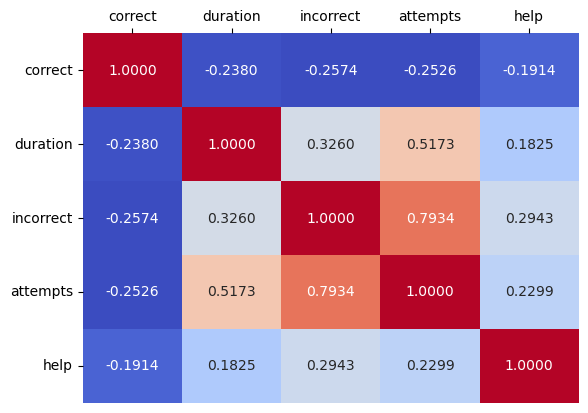

In [445]:
os.chdir('result')
print(os.getcwd())

# Creating a dataframe with columns where we want to see correlation.
df_clean_corr = df_clean[['correct', 'duration', 'incorrect', 'attempts', 'help']]
cols_list = list(df_clean_corr.columns)

# Plot and save correaltion matrix.
fig, ax = plt.subplots()
sns.heatmap(df_clean_corr.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.xaxis.tick_top()
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

In [446]:
df_clean_corr.groupby('correct').mean().round(2)

,duration,incorrect,attempts,help
correct,,,,
0,149.26,7.07,9.53,0.63
1,10.53,0.65,1.68,0.04


### Observation

The correlation with correct answer is negative for all the features.

### Action
The findings will be described more fully in bivariate graphs.

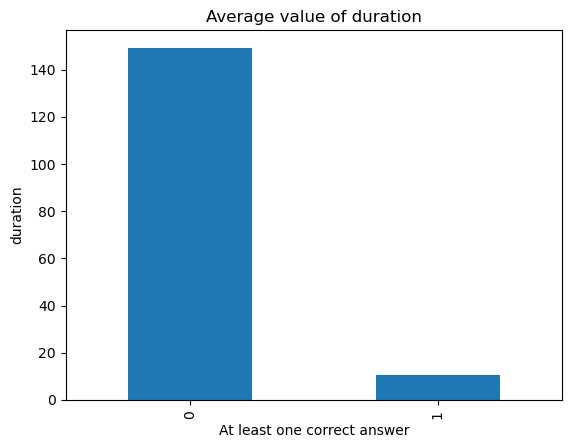

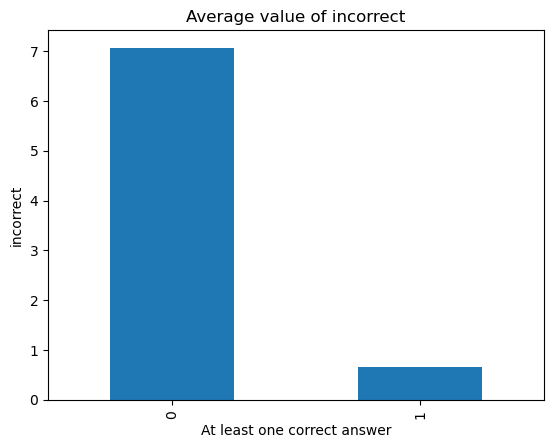

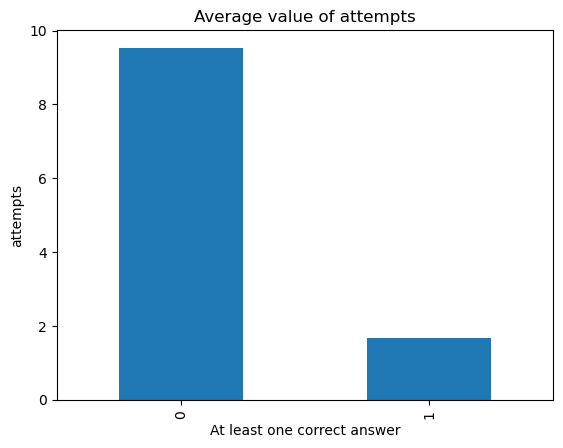

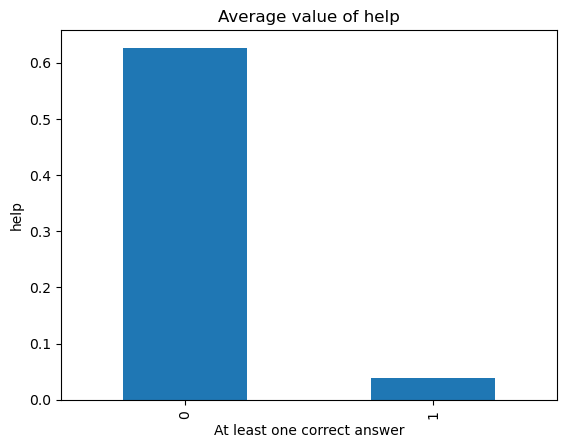

In [448]:
cols_list = ['duration', 'incorrect', 'attempts', 'help']

for item in cols_list:
    df_clean_corr.groupby('correct')[item].mean().plot.bar()
    plt.title(f'Average value of {item}')
    plt.ylabel(item)
    plt.xlabel('At least one correct answer')
    plt.savefig(item)
    plt.show()

In [449]:
print(os.getcwd())

C:\Users\fales\Dropbox\Studier\Python\Data_scientist_nd\course_2\datascience_blogpost\result


In [450]:
os.chdir('..')

In [451]:
print(os.getcwd())

C:\Users\fales\Dropbox\Studier\Python\Data_scientist_nd\course_2\datascience_blogpost
